In [1]:
from scipy.integrate import odeint
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
rg = default_rng(12345)
plt.style.use('seaborn-darkgrid')
NY = 19378104

In [3]:
# method to retrieve COVID19 data from Johns Hopkins website
def get_data():
    # read John Hopkins data from Github
    base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

    # deaths_global = pd.read_csv(base_url + 'time_series_covid19_deaths_global.csv')
    deaths_us = pd.read_csv(base_url + 'time_series_covid19_deaths_US.csv')

    # get latest or current date from data set(s)
    latest_date = deaths_us.columns.values[-1]

    # aggregate data by state (separate highest and lowest states)
    us_drop_columns = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key']
    deaths_us.drop(us_drop_columns + ['Population'], axis=1, inplace=True)
    deaths_us_sorted = deaths_us.groupby('Province_State').agg('sum').sort_values(by=latest_date, ascending=False)

    # only consider states with deaths greater than 50
    us_deaths = deaths_us_sorted[deaths_us_sorted[latest_date] > 50].T
    states = us_deaths.columns.values
    # print(states)

    # set x axis numpy arrays
    num_days = us_deaths.shape[0]
    tdata = np.linspace(0, num_days - 1, num_days)  # x data for curve fit
    ydata = us_deaths['New York'].values
    return np.array(tdata), np.array(ydata)

In [4]:
# SEIR ODE model for Scipy odeint
def fun(y, t, alpha, beta, gamma, delta, lam, kappa, inflect_date):
    S, E, I, Q, R, D, P = y

    dSdt = -beta * S * I / NY - alpha * S
    dEdt = beta * S * I / NY - gamma * E
    dIdt = gamma * E - delta * I
    dQdt = delta * I - lam * Q - kappa * Q
    dRdt = lam * Q
    dDdt = kappa * Q
    dPdt = alpha * S

    if t < inflect_date:
        dSdt = dEdt = dIdt = dQdt = dRdt = dDdt = dPdt = 0
    return [dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt]

In [5]:
# simulator function that provides predicted deaths to facilitate sum square residuals and likelihood esimation
def seir_model(tdata, alpha, beta, gamma, delta, lam, kappa, inflect_date):
    y0 = [0.9 * NY, 0, 0.01 * NY, 0, 0, 0, 0]
    sol = odeint(fun, y0, tdata, args=(alpha, beta, gamma, delta, lam, kappa, inflect_date))
    return sol[:, 5]

In [6]:
# calculated sum square residuals (normalize by max value of actual data)
def likelihood(ytest, ydata):
    ssr = 0.0
    err = np.empty(ydata.shape[0])
    # calculate normalized SSR with linear weighting applied so that most recent results are weighted more
    for i in range(ydata.shape[0]):
        err[i] = 4.0 * (i + 1) * (ytest[i] - ydata[i]) * (ytest[i] - ydata[i]) / ydata[-1] / ydata[-1]
    return np.exp(-0.5 * np.sum(err))

In [7]:
# perform Gibbs sampling of priors for Hamiltonian MCMC
burnin = 1000      # discard the first burnin points
num = 1000000 + burnin
alpha_post = np.empty(num)
beta_post = np.empty(num)
gamma_post = np.empty(num)
delta_post = np.empty(num)
lam_post = np.empty(num)
kappa_post = np.empty(num)
inflect_date_post = np.empty(num)
previous_likelihood = 1.0

# get Johns Hopkins data for New York
tdata, ydata = get_data()
accepted = 0
for idx in range(num):
    # generate priors for parameters (first set of generators)
    # alpha = np.abs(rg.normal(loc=0, scale=0.05))
    # beta = rg.lognormal(mean=np.log(2), sigma=0.25)
    # gamma = np.abs(rg.normal(loc=0, scale=0.2))
    # delta = rg.lognormal(mean=0, sigma=0.1)
    # lam = rg.lognormal(mean=np.log(1.5), sigma=0.25)
    # kappa = np.abs(rg.normal(loc=0, scale=0.005))
    # inflect_date = rg.normal(loc=60, scale=5)
    
    # generate priors for parameters (current generators)
    alpha = rg.uniform(low=0.02, high=0.05)
    beta = rg.uniform(low=1.5, high=2.5)
    gamma = rg.uniform(low=0.1, high=0.2)
    delta = rg.uniform(low=0.4, high=0.6)
    lam = rg.uniform(low=1.5, high=2.5)
    kappa = rg.uniform(low=0.002, high=0.007)
    inflect_date = rg.uniform(low=55, high=65)

    ytest = seir_model(tdata, alpha, beta, gamma, delta, lam, kappa, inflect_date)
    current_likelihood = likelihood(ytest, ydata)
    ratio = current_likelihood / previous_likelihood
    
    # Metropolis Hastings Acceptance Criteria
    if ratio >= rg.uniform(low=0.0, high=1.0):
        accepted += 1
        previous_likelihood = current_likelihood
        alpha_post[idx] = alpha
        beta_post[idx] = beta
        gamma_post[idx] = gamma
        delta_post[idx] = delta
        lam_post[idx] = lam
        kappa_post[idx] = kappa
        inflect_date_post[idx] = inflect_date
    else:
        alpha_post[idx] = alpha_post[idx - 1]
        beta_post[idx] = beta_post[idx - 1]
        gamma_post[idx] = gamma_post[idx - 1]
        delta_post[idx] = delta_post[idx - 1]
        lam_post[idx] = lam_post[idx - 1]
        kappa_post[idx] = kappa_post[idx - 1]
        inflect_date_post[idx] = inflect_date_post[idx - 1]

In [8]:
# determine parameter estimations from means of accepted events (Posterior)
alpha_mu = np.mean(alpha_post[burnin:])
beta_mu = np.mean(beta_post[burnin:])
gamma_mu = np.mean(gamma_post[burnin:])
delta_mu = np.mean(delta_post[burnin:])
lam_mu = np.mean(lam_post[burnin:])
kappa_mu = np.mean(kappa_post[burnin:])
inflect_date_mu = np.mean(inflect_date_post[burnin:])

# determine std error estimations from numpy std of accepted events (Posterior)
alpha_err = np.std(alpha_post[burnin:])
beta_err = np.std(beta_post[burnin:])
gamma_err = np.std(gamma_post[burnin:])
delta_err = np.std(delta_post[burnin:])
lam_err = np.std(lam_post[burnin:])
kappa_err = np.std(kappa_post[burnin:])
inflect_date_err = np.std(inflect_date_post[burnin:])

print("iterations: {}, accepted: {}".format(num, accepted))
print("alpha={:0.4f}, err={:.4f} +/- {:.2f}%".format(alpha_post[-1], alpha_err, 100 * alpha_err / alpha_mu))
print("beta={:0.2f}, err={:.2f} +/- {:.2f}%".format(beta_post[-1], beta_err, 100 * beta_err / beta_mu))
print("gamma={:0.3f}, err={:.3f} +/- {:.2f}%".format(gamma_post[-1], gamma_err, 100 * gamma_err / gamma_mu))
print("delta={:0.3f}, err={:.3f} +/- {:.2f}%".format(delta_post[-1], delta_err, 100 * delta_err / delta_mu))
print("lambda={:0.2f}, err={:.2f} +/- {:.2f}%".format(lam_post[-1], lam_err, 100 * lam_err / lam_mu))
print("kappa={:0.5f}, err={:.5f} +/- {:.2f}%".format(kappa_post[-1], kappa_err, 100 * kappa_err / kappa_mu))
print("inflect data={:0.1f}, err={:.4f} +/- {:.2f}%".format(inflect_date_post[-1], inflect_date_err, 100 * inflect_date_err / inflect_date_mu))

iterations: 1001000, accepted: 391
alpha=0.0328, err=0.0071 +/- 25.30%
beta=2.12, err=0.38 +/- 18.71%
gamma=0.105, err=0.021 +/- 19.12%
delta=0.470, err=0.092 +/- 18.70%
lambda=1.83, err=0.37 +/- 20.29%
kappa=0.00611, err=0.00114 +/- 19.54%
inflect data=57.2, err=8.3478 +/- 15.07%


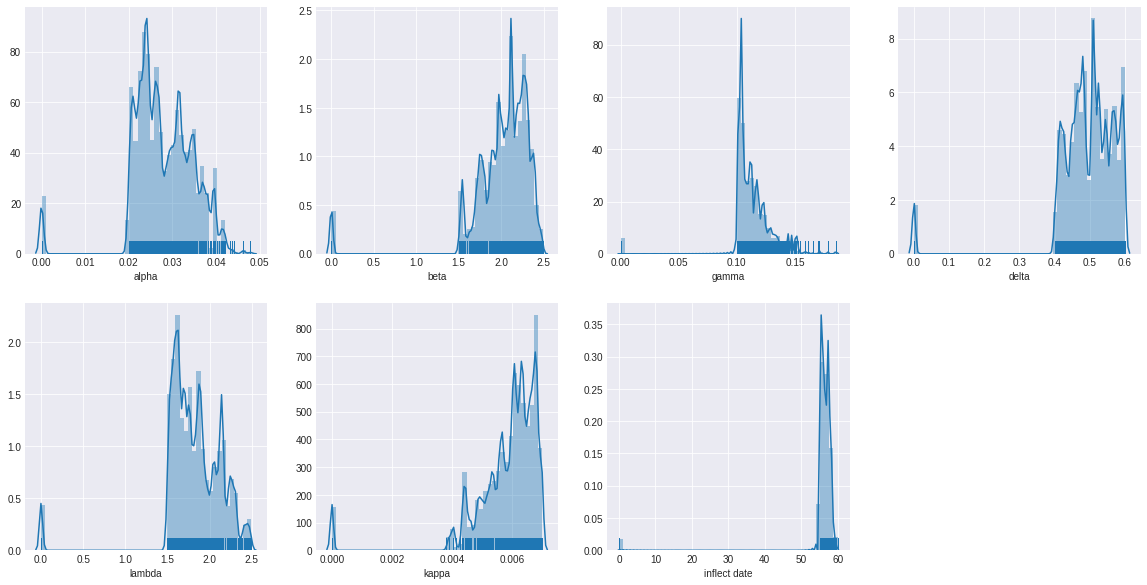

In [9]:
# Plot posterior distributions 
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 4)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[1,0])
ax6 = fig.add_subplot(gs[1,1])
ax7 = fig.add_subplot(gs[1,2])
sns.distplot(alpha_post[burnin:], ax=ax1, norm_hist=True, rug=True, axlabel='alpha')
sns.distplot(beta_post[burnin:], ax=ax2, norm_hist=True, rug=True, axlabel='beta')
sns.distplot(gamma_post[burnin:], ax=ax3, norm_hist=True, rug=True, axlabel='gamma')
sns.distplot(delta_post[burnin:], ax=ax4, norm_hist=True, rug=True, axlabel='delta')
sns.distplot(lam_post[burnin:], ax=ax5, norm_hist=True, rug=True, axlabel='lambda')
sns.distplot(kappa_post[burnin:], ax=ax6, norm_hist=True, rug=True, axlabel='kappa')
sns.distplot(inflect_date_post[burnin:], ax=ax7, norm_hist=True, rug=True, axlabel='inflect date')
plt.show()

In [10]:
# recalculate SEIR model with results from Hamiltonian MCMC
y0 = [0.9 * NY, 0, 0.01 * NY, 0, 0, 0, 0]
numdates = 130
t = np.linspace(0, numdates - 1, numdates)
sol = odeint(fun, y0, t, args=(alpha_mu, beta_mu, gamma_mu, delta_mu, lam_mu, kappa_mu, inflect_date_mu))

import datetime
base = datetime.datetime(2020, 1, 22)
arr = np.array([base + datetime.timedelta(days=i) for i in range(numdates)])  # x data as dates for plots
print("actual inflection date={}".format(arr[int(inflect_date)].strftime('%d %B %Y')))

actual inflection date=18 March 2020


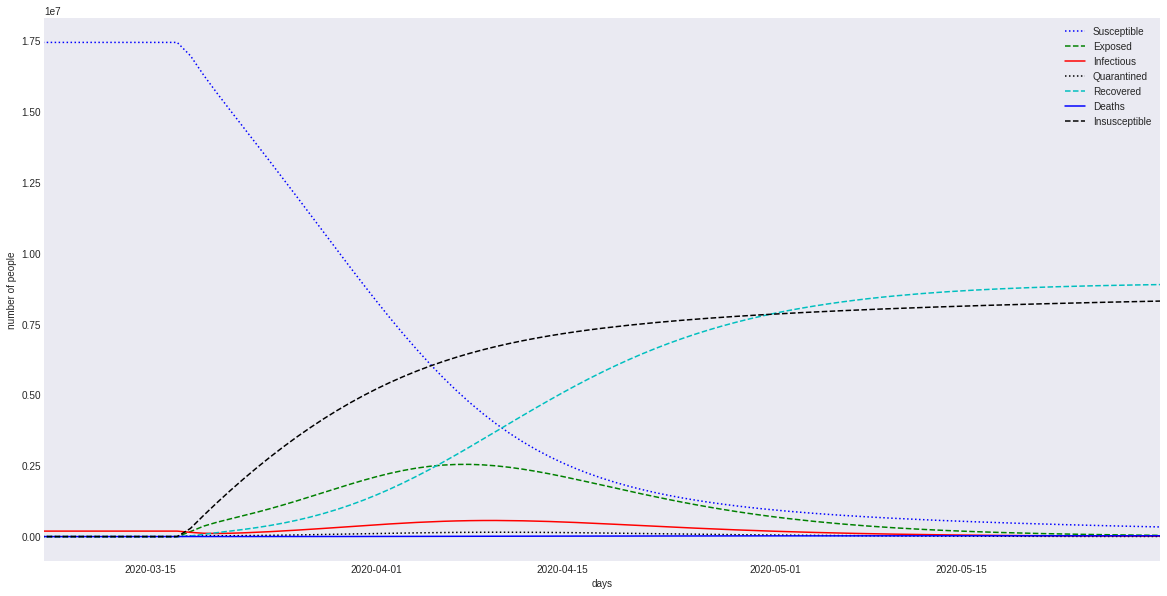

In [11]:
# plot results
fig = plt.figure(figsize=(20, 10))
plt.plot(arr, sol[:, 0], 'b', label='Susceptible', linestyle=':')
plt.plot(arr, sol[:, 1], 'g', label='Exposed', linestyle='--')
plt.plot(arr, sol[:, 2], 'r', label='Infectious')
plt.plot(arr, sol[:, 3], 'k', label='Quarantined', linestyle=':')
plt.plot(arr, sol[:, 4], 'c', label='Recovered', linestyle='--')
plt.plot(arr, sol[:, 5], 'b', label='Deaths')
plt.plot(arr, sol[:, 6], 'k', label='Insusceptible', linestyle='--')
plt.xlim(arr[45], arr[-1])
plt.legend(loc='best')
plt.xlabel('days')
plt.ylabel('number of people')
plt.grid()
plt.show()

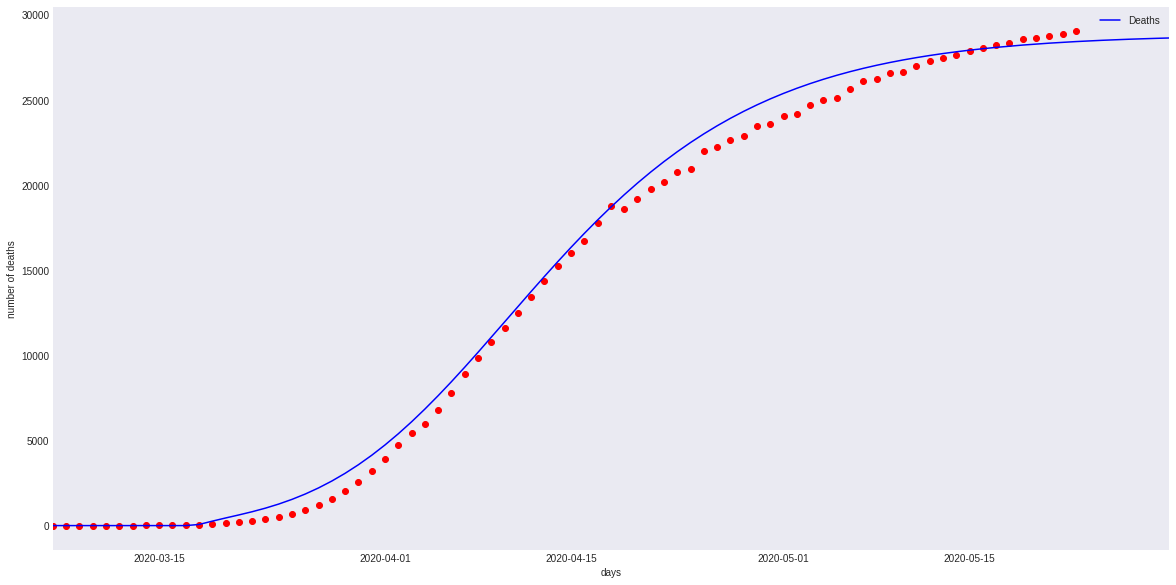

In [12]:
# plot COVID19 deaths vs actuals
fig = plt.figure(figsize=(20, 10))
plt.plot(arr[0: len(ydata)], ydata, 'ro')
plt.plot(arr, sol[:, 5], 'b', label='Deaths')
plt.legend(loc='best')
plt.xlabel('days')
plt.ylabel('number of deaths')
plt.xlim(arr[45], arr[-1])
plt.grid()
plt.show()